In [1]:
import sklearn
import os
from tqdm.autonotebook import tqdm
import numpy as np
from PIL import Image
import pandas as pd
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, load_model, Model 
from keras.layers import Conv2D, MaxPool2D, Add, Dense, Reshape, Flatten, Dropout, BatchNormalization, ReLU, Activation, Concatenate, Flatten, Input, Concatenate, Activation, LSTM, Bidirectional, Lambda
from keras import Input
from keras import backend
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# check GPU
!nvidia-smi

Sun Jul 31 17:00:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unzip "/content/gdrive/MyDrive/AI Draw Equation/AIDE dataset.zip" -d "/content"

In [7]:
# Load train and val dataset
list_categories = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "add", "dec", "div", "mul", "stroke", "sub", "(", ")"]
train_path = "/content/AIDE dataset/train"
X_train = []
Y_train = []
for label_folder in os.listdir(train_path):
  curr_path = os.path.join(train_path, label_folder)
  lbl = list_categories.index(label_folder)
  for img_name in os.listdir(curr_path):
    img = cv2.imread(os.path.join(curr_path, img_name), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    X_train.append(img)
    Y_train.append(int(lbl))
X_train = np.array(X_train) / 255.0
Y_train = np.array(Y_train)

val_path = "/content/AIDE dataset/val"
X_val = []
Y_val = []
for label_folder in os.listdir(val_path):
  curr_path = os.path.join(val_path, label_folder)
  lbl = list_categories.index(label_folder)
  for img_name in os.listdir(curr_path):
    img = cv2.imread(os.path.join(curr_path, img_name), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    X_val.append(img)
    Y_val.append(int(lbl))
X_val = np.array(X_val) / 255.0
Y_val = np.array(Y_val)

Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)

In [8]:
print(f"Number of train samples: {X_train.shape[0]}")
print(f"Number of val samples: {X_val.shape[0]}")

Number of train samples: 11394
Number of val samples: 3806


In [9]:
cv2_imshow(X_train[9] * 255)
print(Y_train[9])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [10]:
# Define model
input_img = Input(shape=(28, 28 , 1), name="input")
x = Conv2D(filters = 6, kernel_size = (5, 5), strides = 1, padding = "same", activation = "tanh")(input_img)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(filters = 16, kernel_size = (5, 5), strides = 1, padding = "same", activation = "tanh")(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(120, activation='relu')(x)
x = Dense(84, activation='relu')(x)
output = Dense(18, activation='softmax')(x)
model = Model(inputs = input_img, outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 784)               0     

In [11]:
lr = 0.001
opt = keras.optimizers.Adam(learning_rate = lr)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
train = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 50, batch_size = 32, verbose = 1)  

Epoch 1/50
357/357 [==============================] - 5s 5ms/step - loss: 1.5371 - accuracy: 0.5398 - val_loss: 0.9191 - val_accuracy: 0.7063
Epoch 2/50
357/357 [==============================] - 2s 5ms/step - loss: 0.7086 - accuracy: 0.7728 - val_loss: 0.5297 - val_accuracy: 0.8452
Epoch 3/50
357/357 [==============================] - 3s 7ms/step - loss: 0.4476 - accuracy: 0.8617 - val_loss: 0.4060 - val_accuracy: 0.8783
Epoch 4/50
357/357 [==============================] - 2s 4ms/step - loss: 0.3221 - accuracy: 0.9023 - val_loss: 0.3120 - val_accuracy: 0.9073
Epoch 5/50
357/357 [==============================] - 2s 4ms/step - loss: 0.2496 - accuracy: 0.9235 - val_loss: 0.2817 - val_accuracy: 0.9138
Epoch 6/50
357/357 [==============================] - 2s 4ms/step - loss: 0.2082 - accuracy: 0.9375 - val_loss: 0.2438 - val_accuracy: 0.9291
Epoch 7/50
357/357 [==============================] - 2s 5ms/step - loss: 0.1643 - accuracy: 0.9492 - val_loss: 0.2218 - val_accuracy: 0.9354
Epoch 

In [19]:
# Load test 
test_path = "/content/AIDE dataset/test"
X_test = []
Y_test = []
for label_folder in os.listdir(test_path):
  curr_path = os.path.join(test_path, label_folder)
  lbl = list_categories.index(label_folder)
  for img_name in os.listdir(curr_path):
    img = cv2.imread(os.path.join(curr_path, img_name), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    X_test.append(img)
    Y_test.append(int(lbl))
X_test = np.array(X_test) / 255.0
Y_test = np.array(Y_test)

Y_test = to_categorical(Y_test)

In [20]:
print(X_test.shape)
print(Y_test.shape)

(3807, 28, 28)
(3807, 18)


In [21]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print("Loss = ", test_loss)
print("Evaluation Accuracy = ", test_accuracy * 100)

Loss =  0.23490725457668304
Accuracy =  96.27003073692322


In [25]:
count = 0
for i in range(X_test.shape[0]):
  pred = model.predict(X_test[i].reshape(1, 28, 28, 1))
  pred = list_categories[np.argmax(pred)]
  true = list_categories[np.argmax(Y_test[i])]
  if pred == true:
    count += 1
print(f"Test Accuracy: {count / X_test.shape[0]}")

Test Accuracy: 0.9627002889414237


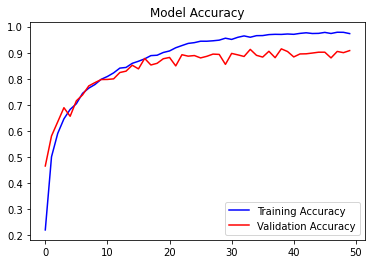

In [ ]:
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

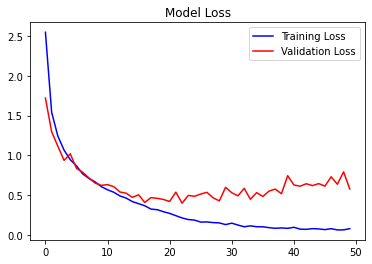

In [ ]:
train_loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(train_loss))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
model_json = model.to_json()
with open(f"/content/gdrive/MyDrive/AI Draw Equation/Model/Lenet lr={lr}.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(f"/content/gdrive/MyDrive/AI Draw Equation/Model/Lenet lr={lr}.h5")